# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [921]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from parse_results import process_results_xml
import yaml
#import influxdb_client

In [922]:
settings_file = Path('settings.yaml')

if settings_file.exists():
    with settings_file.open() as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
else:
    params = {}
    
sert_results_dir = params.get('results_dir', 'sert_results')
bios_setting_file = params.get('test_settings', 'test_settings.csv')
cpu_metrics_dir = params.get('cpu_metrics_dir', 'cpu_data')

working_dir_path = params.get('temp_dir', 'temp_dir')
all_data_file = params.get('data_file', 'all_data.csv')
overwrite_data = params.get('overwrite_data', False)

whitelist = params.get('whitelist', '')

working_dir = Path(working_dir_path)

# Generate and load the data (Run Once)

In [923]:
def aggregate_sert(file, test_name, test_details, params):
    # Load the SERT result
    metrics, score, env = process_results_xml(f)
    
    # METRICS
    metrics_df = pd.DataFrame.from_records(metrics)
    # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
    calibrations = metrics_df.loc[metrics_df['loadlevel']=='calibration', ['worklet', 'score']]
    calibrations = calibrations.rename(columns={'score': 'calibration-score'})

    metrics_df = pd.merge(metrics_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
    metrics_df['actual-load'] = metrics_df['score'] / metrics_df['calibration-score']
    metrics_df.loc[metrics_df['workload'] == 'Idle', 'actual-load'] = 0
    metrics_df['test-name'] = test_name
    
    if test_details['location'].get(test_name) == 'Tunnel':
        if 'influxdb' in params:
            metrics_df['pressure'] = get_tunnel_pressure(metrics_df, params)
        else:
            # Can't get tunnel data without influx credentials
            metrics_df['pressure'] = np.nan
    else:
        metrics_df['pressure'] = 0.0

    # SCORE
    score_df = pd.DataFrame.from_records(score)
    score_df['test-name'] = test_name
    
    # ENV
    env_df = pd.DataFrame.from_records(env, index=[test_name])
    # Test details are "unknwon" if not in the test_details csv
    env_df['location'] = test_details['location'].get(test_name, 'unknown')
    env_df['bios'] = test_details['bios'].get(test_name, 'unknown')
    
    return metrics_df, env_df, score_df
    
def get_tunnel_pressure(metrics, params):
    from influxdb import InfluxDBClient
    client = InfluxDBClient(host=params['influxdb']['host'], 
                            port=params['influxdb']['port'], 
                            username=params['influxdb']['user'], 
                            password=params['influxdb']['password'],
                            database=params['influxdb']['tunnel-database'])
    
    return metrics.apply(get_pressure_row,  axis=1, client=client)
    
def get_pressure_row(r, client):
    query = f'select (mean("value")-21.65)*62/19 from sensors where "channel"=\'Pressure\' and time>=\'{r.start.isoformat()}\' and time<=\'{r.end.isoformat()}\''
    result = client.query(query)
    for pt in result.get_points('sensors'):
        return pt['mean']

    return np.nan # Tunnel run but no data    
    

# Ensure the working directory exists
if not working_dir.exists():
    working_dir.mkdir(parents=True)

# Temp files
metrics_path = working_dir.joinpath('metrics.csv')
scores_path = working_dir.joinpath('scores.csv')
details_path = working_dir.joinpath('test_details.csv')

    
# Load any existing chached data or start empty if they don't exist
if working_dir.joinpath('metrics.csv').exists() and not overwrite_data:
    print('Loading SERT data from disk')
    try:
        metrics_data = pd.read_csv(str(metrics_path), parse_dates=['start', 'end'])
        scores = pd.read_csv(str(scores_path))
        test_details = pd.read_csv(str(details_path), index_col=0)
    except Exception as e:
        print('Reloading failed, exception: ', e, '\nRebuilding...')
        metrics_data = pd.DataFrame()
        test_details = pd.DataFrame()
        scores = pd.DataFrame()
else:
    print('Rebuilding SERT results data.....')
    metrics_data = pd.DataFrame()
    test_details = pd.DataFrame()
    scores = pd.DataFrame()

# Load external details for test
if bios_setting_file != '' and Path(bios_setting_file).is_file():
    settings = pd.read_csv(bios_setting_file, index_col=0)
else:
    settings = pd.DataFrame(columns=['location', 'bios'])
    
# Find any results in the results directory that aren't already in the dataframes, but only look for results that are valid or in the whitelist
source_path = Path(sert_results_dir)
new_results = [x for x in source_path.glob('**//results.xml') if x.parent.name not in test_details.index and 
                                                               (not x.parent.joinpath('invalid.png').exists() or x.parent.name in whitelist)]

for f in new_results:     
    try:
        metrics, details, score = aggregate_sert(str(f), f.parent.name, settings, params)

        metrics_data = metrics_data.append(metrics, ignore_index=True)
        test_details = test_details.append(details)
        scores = scores.append(score, ignore_index=True)

    except Exception as e:
        print(f, ': FAILED TO LOAD -- ', e, type(e))

        
# Store the new metrics
if len(new_results) > 0:
    # Store generated data
    metrics_data.to_csv(str(metrics_path), index=False)
    test_details.to_csv(str(details_path))
    scores.to_csv(str(scores_path), index=False)

Loading SERT data from disk
C:\Users\D.Burdett\OneDrive - Techbuyer Group\Tunnel\Results - PowerEdge\sert-0030\results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
C:\Users\D.Burdett\OneDrive - Techbuyer Group\Tunnel\Results - PowerEdge\sert-0064\results.xml : FAILED TO LOAD --  The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all(). <class 'ValueError'>
C:\Users\D.Burdett\OneDrive - Techbuyer Group\Tunnel\Results - PowerEdge\sert-0101\results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
C:\Users\D.Burdett\OneDrive - Techbuyer Group\Tunnel\Results - PowerEdge\sert-0106\results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'find' <class 'AttributeError'>
C:\Users\D.Burdett\OneDrive - Techbuyer Group\Tunnel\Results - PowerEdge\sert-0167\results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'find' <class 'AttributeError'>
C:\Users

In [924]:
# Set this to True if you haven't run the previous cell and want to just load the data from last time.
reload_from_cached = False

data_cache_path = working_dir.joinpath(all_data_file)

if reload_from_cached and data_cache_path.exists():
    sert_data = pd.read_csv(str(data_cache_path), parse_dates=['start', 'end'])
else:        
    # Build the combined view for analysis

    # Join metrics, test details and scores into a big view table
    sert_data = pd.merge(metrics_data, scores[['test-name', 'worklet', 'loadlevel', 'norm-score', 'ref-score', 'efficiency-score']], how='left', on=['test-name', 'worklet', 'loadlevel'])
    sert_data = pd.merge(sert_data, test_details, left_on='test-name', right_index=True)

    # Scenario column for easier display and filtering
    sert_data['scenario'] = list(' - '.join(s) for s in zip(sert_data['model'], sert_data['cpu']))

    # Drop any tests that were run without hyperthreading
    sert_data.drop(sert_data[sert_data.logical_cores == sert_data.physical_cores].index, inplace=True)
    
    # Save a cache of the joins
    sert_data.to_csv(str(data_cache_path), index=False)

In [925]:
sert_data.head()    

,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,temp-min,...,logical_cores,model,numa_nodes,physical_cores,psu,ref,vendor,location,bios,scenario
0,100%,Compress,30626.914905,CPU,443.60,459.90,453.219355,2021-07-20 17:09:13.563000+01:00,2021-07-20 17:10:14.073000+01:00,21.6875,...,32,PowerEdge R620,2,16,750,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...
1,75%,Compress,23033.399704,CPU,394.53,399.82,396.494194,2021-07-20 17:10:26.424000+01:00,2021-07-20 17:11:26.680000+01:00,21.6875,...,32,PowerEdge R620,2,16,750,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...
2,50%,Compress,15363.588340,CPU,336.89,341.17,338.587097,2021-07-20 17:11:39.005000+01:00,2021-07-20 17:12:39.239000+01:00,21.7500,...,32,PowerEdge R620,2,16,750,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...
3,25%,Compress,7655.040348,CPU,282.27,285.81,283.971935,2021-07-20 17:12:50.569000+01:00,2021-07-20 17:13:50.798000+01:00,21.6875,...,32,PowerEdge R620,2,16,750,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...
4,100%,CryptoAES,244416.106977,CPU,434.90,441.10,438.122581,2021-07-20 17:18:51.563000+01:00,2021-07-20 17:19:52.073000+01:00,21.7500,...,32,PowerEdge R620,2,16,750,R620-HighP-MidT,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...


In [926]:
sert_data.describe()

,score,watts-min,watts-max,watts-avg,temp-min,temp-max,temp-avg,calibration-score,actual-load,pressure,norm-score,ref-score,efficiency-score,dimm_size_mb,dimms,logical_cores,numa_nodes,physical_cores,psu
count,1.017000e+04,10170.000000,10170.000000,10170.000000,10170.000000,10170.000000,10170.000000,8.930000e+03,9178.000000,9936.000000,9922.000000,9922.000000,9922.000000,10170.0,10170.0,10170.000000,10170.00000,10170.000000,10170.0
mean,4.258728e+05,246.424769,254.081304,249.773668,23.915628,23.959993,23.938687,5.721019e+05,0.608439,10.128739,4.588648,90114.731256,17.193544,8192.0,8.0,52.715044,3.33884,21.838348,750.0
std,8.764744e+05,98.595712,100.936789,99.802783,2.598148,2.600651,2.599393,9.080482e+05,0.296990,12.172156,4.922538,136001.400351,13.727797,0.0,0.0,15.760475,0.94089,2.957699,0.0
min,0.000000e+00,67.550000,69.590000,68.368525,20.000000,20.062500,20.008929,1.852853e+02,0.000000,-9.341460,0.468478,11.520000,2.095409,8192.0,8.0,32.000000,2.00000,16.000000,750.0
25%,7.337100e+03,177.270000,182.305000,179.969993,21.500000,21.562500,21.517857,3.618265e+04,0.374158,0.000000,2.067897,6924.400000,9.990818,8192.0,8.0,48.000000,2.00000,20.000000,750.0
50%,5.806126e+04,225.830000,231.510000,228.050554,23.750000,23.812500,23.785714,9.131609e+04,0.503219,2.429429,3.608587,15946.510000,15.187872,8192.0,8.0,48.000000,4.00000,24.000000,750.0
75%,3.065363e+05,316.965000,327.445000,322.102581,26.125000,26.187500,26.151786,3.712614e+05,0.876283,24.994766,5.437222,59008.110000,20.400395,8192.0,8.0,48.000000,4.00000,24.000000,750.0
max,6.662897e+06,503.100000,508.800000,505.467742,34.000000,34.000000,34.000000,3.071580e+06,1.086627,32.210291,44.990631,354112.340000,106.013770,8192.0,8.0,80.000000,4.00000,28.000000,750.0


In [927]:
#test_details
total_score = scores[scores['workload'] == 'All'].dropna(axis=1)
total_score = total_score.merge(test_details, left_on='test-name', right_index=True, how='left').dropna()
total_score['scenario'] = list(' - '.join(x) for x in zip(total_score['model'], total_score['cpu']))
total_score['temperature'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-avg'].mean(), axis=1)
total_score['temperature-range'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-max'].max() - sert_data[sert_data['test-name'] == row['test-name']]['temp-min'].min(), axis=1)
total_score = total_score.merge(sert_data[sert_data['workload'] == 'Idle'][['watts-avg','test-name']], left_on='test-name', right_on='test-name').rename(columns={'watts-avg':'idle-power'})
total_score['max-power'] = total_score.apply(lambda row: sert_data[(sert_data['test-name'] == row['test-name']) & (sert_data['loadlevel']=='100%')]['watts-avg'].mean(), axis=1)
total_score['pressure'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['pressure'].mean(), axis=1)

total_score['pressure-bound'] = pd.cut(total_score['pressure'],[total_score.pressure.min(), 15, total_score.pressure.max()],labels=['low','high'])
total_score

,workload,efficiency-score,test-name,cpu,dimm_size_mb,dimms,hostname,logical_cores,model,numa_nodes,...,vendor,location,bios,scenario,temperature,temperature-range,idle-power,max-power,pressure,pressure-bound
0,All,8.920446,sert-0020,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.685482,0.3125,224.993607,376.521255,30.230610,high
1,All,8.953276,sert-0021,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.511090,0.3125,224.660164,374.651764,30.249636,high
2,All,8.928965,sert-0022,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.369713,0.3125,224.571148,375.715063,30.212243,high
3,All,8.947380,sert-0023,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.262872,0.2500,224.413115,374.851773,30.255844,high
4,All,8.953668,sert-0024,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,Tunnel,Performance,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,21.175232,0.2500,225.020984,374.474790,30.259437,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,All,17.853071,sert-0480,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,Dell Inc.,Tunnel,Performance,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,26.743966,1.3750,222.761639,412.419160,25.408163,high
244,All,18.148622,sert-0481,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,Dell Inc.,Tunnel,Performance,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,26.780515,1.3125,222.788689,414.179417,25.386895,high
245,All,17.815846,sert-0483,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,Dell Inc.,Tunnel,Performance,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,26.767030,1.3125,225.833115,414.235251,2.472819,low
246,All,18.071783,sert-0484,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,Dell Inc.,Tunnel,Performance,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,26.901969,1.3750,225.459016,417.430388,2.516688,low


# What scenarios have been tested?
Using a 3 bin strategy for temperature testing and high and low for pressure.

In [928]:
tested = total_score.groupby(['scenario', 'bios', total_score['pressure-bound'], pd.cut(total_score.temperature,[20, 23.33,26.66, 30])]).size().unstack().unstack()
tested.style.applymap(lambda x: 'background-color:pink' if x < 3 else None)

In [929]:
total_score[(total_score['bios'] == 'unknown')]

,workload,efficiency-score,test-name,cpu,dimm_size_mb,dimms,hostname,logical_cores,model,numa_nodes,...,vendor,location,bios,scenario,temperature,temperature-range,idle-power,max-power,pressure,pressure-bound
21,All,8.321074,sert-0054,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,unknown,unknown,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,29.479514,6.3750,241.863115,408.458388,0.0,low
26,All,8.781339,sert-0061,Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz,8192,8,R620-1,32,PowerEdge R620,2,...,Dell Inc.,unknown,unknown,PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 ...,23.933851,1.4375,235.913443,379.472220,0.0,low
47,All,20.119521,sert-0099,Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz,8192,8,R630,56,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2697 ...,22.921185,1.0625,95.979180,334.490755,0.0,low
48,All,20.022692,sert-0103,Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz,8192,8,R630,56,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2697 ...,24.623022,0.9375,96.528033,335.975605,0.0,low
49,All,19.994964,sert-0105,Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz,8192,8,R630,56,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2697 ...,24.617428,1.1250,93.136885,339.010465,0.0,low
50,All,20.359447,sert-0108,Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz,8192,8,R630,48,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 ...,23.105234,1.3750,88.990000,301.203474,0.0,low
51,All,15.366984,sert-0128,Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz,8192,8,R630,48,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 ...,22.764754,1.1250,203.781803,340.058321,0.0,low
52,All,15.456082,sert-0129,Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz,8192,8,R630,48,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 ...,22.366256,0.7500,203.195902,339.419431,0.0,low
53,All,15.029373,sert-0133,Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz,8192,8,R630,48,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 ...,23.475647,0.6250,203.735246,342.308364,0.0,low
55,All,15.202717,sert-0135,Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz,8192,8,R630,48,PowerEdge R630,2,...,Dell Inc.,unknown,unknown,PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 ...,21.653261,0.7500,202.096721,338.470322,0.0,low


In [930]:
sert_data = sert_data[(sert_data['bios'] == 'Performance')| (sert_data['bios'] == 'Efficiency')]

total_score = total_score[(total_score['bios'] == 'Performance')| (total_score['bios'] == 'Efficiency')]

In [931]:
sert_data['pressure-bound'] = pd.cut(sert_data['pressure'],[sert_data.pressure.min(), 15, sert_data.pressure.max()],labels=['low','high'])

Mean
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      24.112291
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     21.759720
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     21.570111
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      23.897922
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    24.444923
Name: temp-avg, dtype: float64

Variance
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      5.282507
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     0.835946
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     1.265041
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      7.223818
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    6.942223
Name: temp-avg, dtype: float64


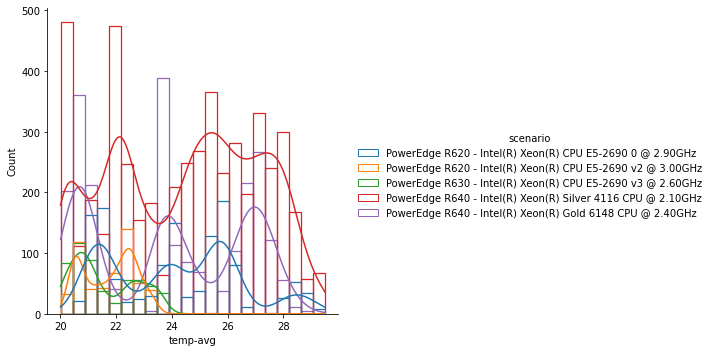

In [932]:
print('Mean\n', sert_data.groupby('scenario')['temp-avg'].mean())
print('\nVariance\n', sert_data.groupby('scenario')['temp-avg'].var())
sns.displot(data=sert_data, x="temp-avg", hue="scenario", kde=True, fill=False)

C:\Users\D.Burdett\Anaconda3\envs\data-analysis\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


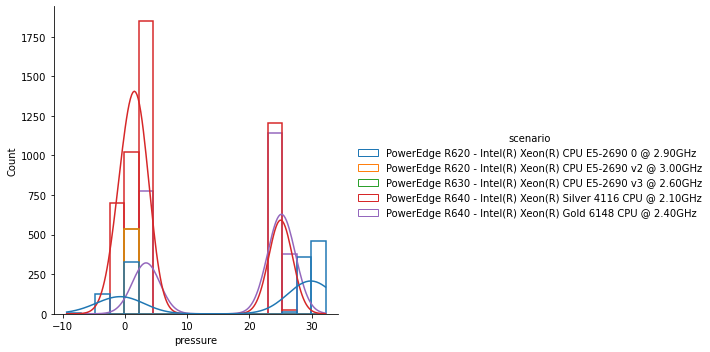

In [933]:
sns.displot(data=sert_data, x="pressure", hue="scenario", kde=True, fill=False)

In [934]:
print(list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['test-name'].unique()), list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['bios'].unique()))

[] []


# Effects on overall SERT score

# Efficiency and power consumption measured by SERT

For the CPU workelts in particular, we can plot the benchmark load against the efficiency score achevied for each scenario. 

Text(0.5, 1.1, 'CPU Worklet Power Consumption')

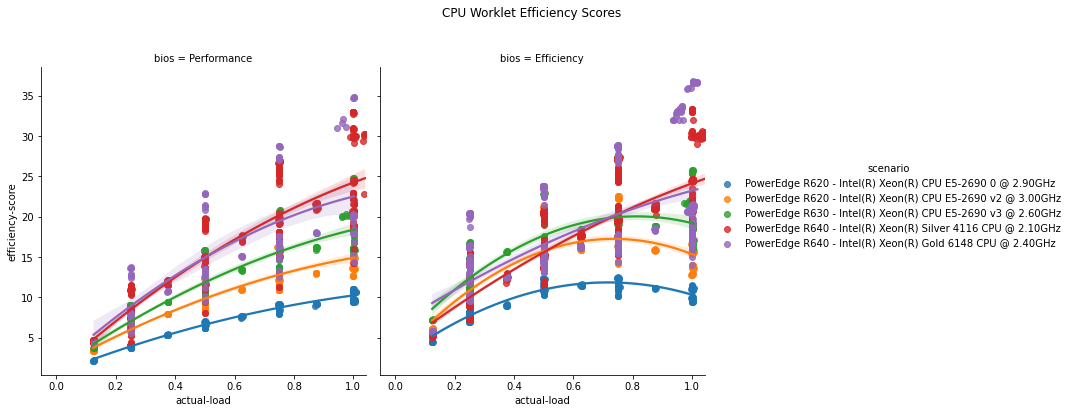

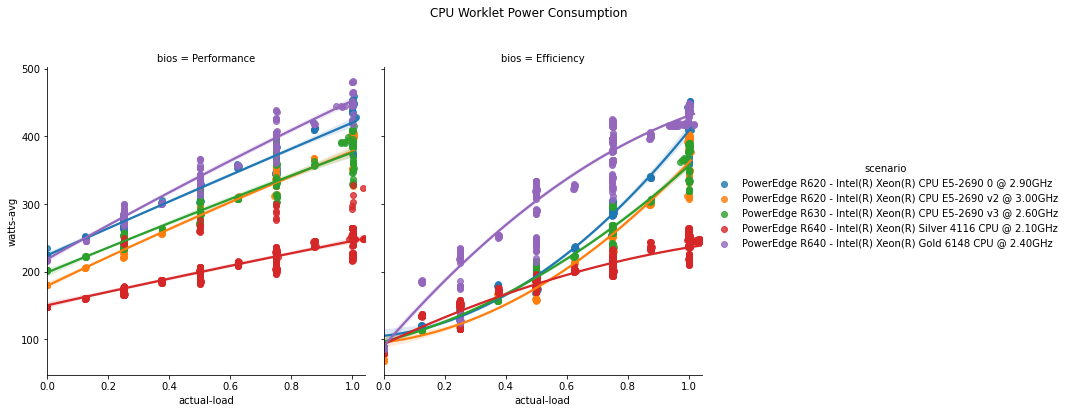

In [935]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]

sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)

A cleaner plot without the individual data plotted for each sert run. 

Text(0.5, 1.0, 'CPU Worklet Efficiency Scores ( Test Temperature < 30C)')

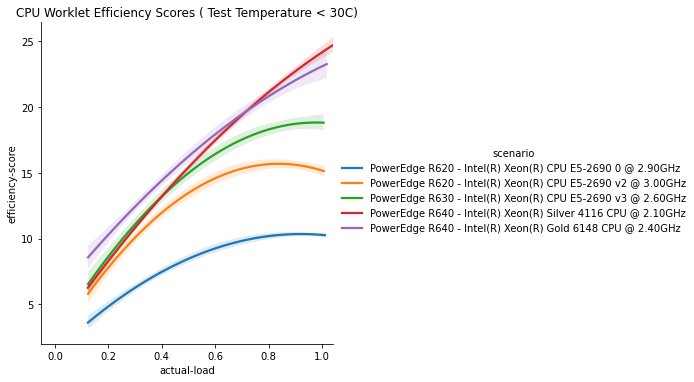

In [936]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', data=cpu[cpu['temp-avg'] < 23.66], order=2, truncate=True, scatter=False)
ax = plt.gca()
ax.set_title('CPU Worklet Efficiency Scores ( Test Temperature < 30C)')

The environmental conditions for the tests are as follows:

# The Effect of Temperature
The overall efficiency score across various temperatures

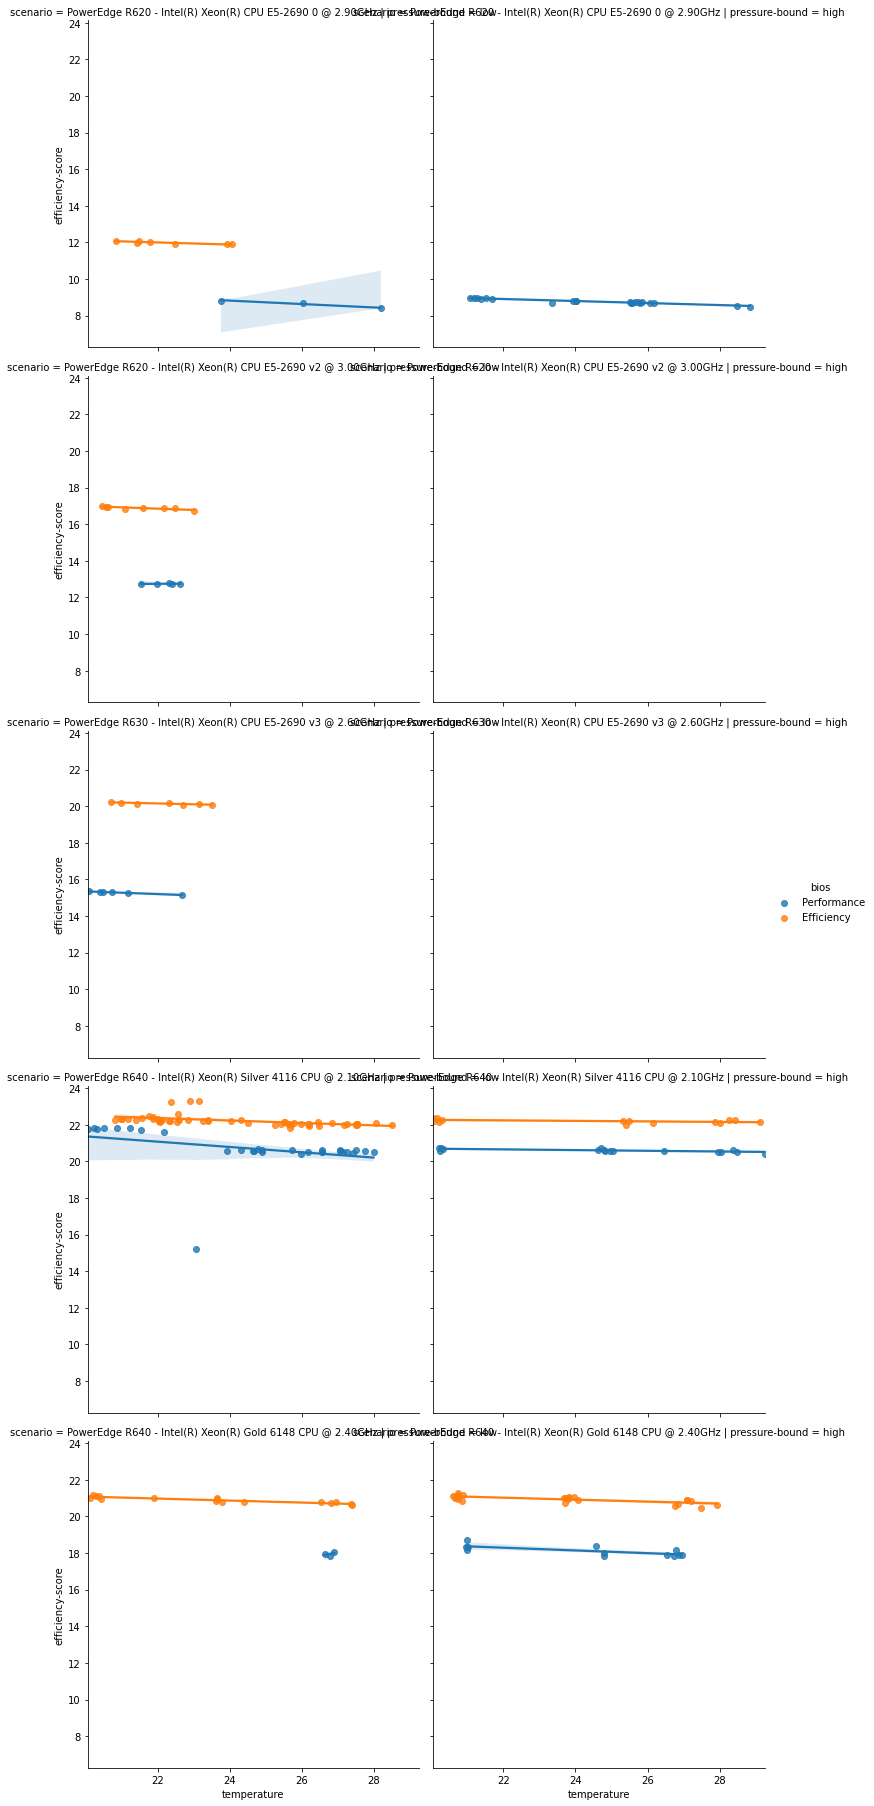

In [937]:
sns.lmplot(data=total_score, x='temperature', y='efficiency-score', hue='bios', row='scenario', col='pressure-bound')

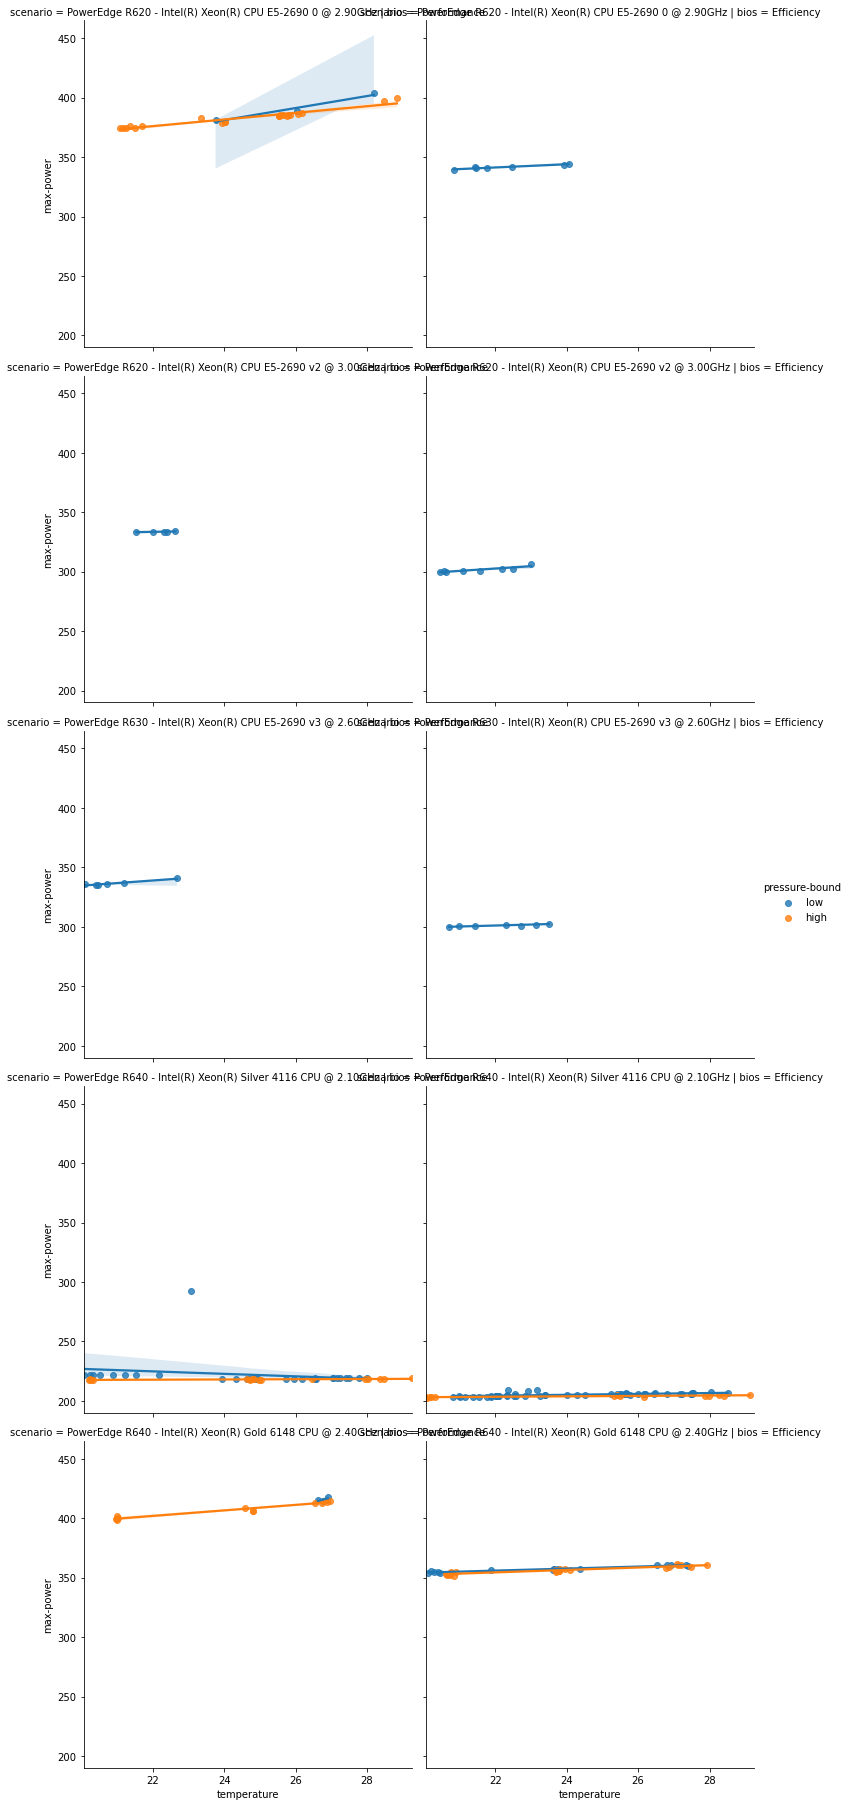

In [938]:
sns.lmplot(data=total_score, x='temperature', y='max-power', hue='pressure-bound', row='scenario', col='bios')

In [939]:
total_score[total_score['temperature'] < 22].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()


efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency          12.037269   
                                                   Performance          8.942559   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency          16.928111   
                                                   Performance         12.740748   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency          20.190678   
                                                   Performance         15.305247   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency          21.071382   
                                                   Performance         18.373547   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency          22.310756   
                                                   Performance         21.376266   

                                                                temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency     21.380781   
                                                   Performance    21.347824   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency     20.859912   
                                                   Performance    21.768351   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency     21.044298   
                                                   Performance    20.584085   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency     20.668024   
                                                   Performance    20.991100   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency     20.948800   
                                                   Performance    20.533201   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency    87.911557   
                                                   Performance  224.827104   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency    68.950525   
                                                   Performance  180.414099   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency    87.944973   
                                                   Performance  202.128262   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency    86.360502   
                                                   Performance  216.690984   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency    83.984218   
                                                   Performance  147.807914   

                                                                 max-power  
scenario                                           bios                     
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency   340.473106  
                                                   Performance  375.170355  
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency   300.372455  
                                                   Performance  333.451099  
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency   300.358096  
                                                   Performance  335.828491  
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency   353.799598  
                                                   Performance  399.907067  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency   203.384250  
                                                   Performance  220.491421

In [940]:
total_score[total_score['temperature'] > 28].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()

efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance          8.471665   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency          22.150179   
                                                   Performance         20.513576   

                                                                temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance    28.499776   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency     28.472061   
                                                   Performance    28.529895   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance  237.742732   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency    82.458015   
                                                   Performance  149.081781   

                                                                 max-power  
scenario                                           bios                     
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance  400.241379  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency   205.728675  
                                                   Performance  218.560985

In [941]:
cpu[(cpu['loadlevel'] == '100%')].groupby([ 'worklet','scenario', 'bios'])['norm-score'].mean().unstack().pct_change(axis=1).abs().mean()

bios
Efficiency         NaN
Performance    0.00766
dtype: float64

In [942]:
cpu[(cpu.model == 'PowerEdge R640') & (cpu.worklet == 'CryptoAES') & (cpu.loadlevel == '100%')].groupby('bios')['norm-score'].mean()

bios
Efficiency     6.417083
Performance    6.436822
Name: norm-score, dtype: float64

In [943]:
cpu[['worklet', 'loadlevel', 'scenario', 'bios', 'score']].groupby(['scenario', 'bios', 'worklet', 'loadlevel']).mean()

score
scenario                                           bios        worklet   loadlevel              
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency  Compress  100%       3.051615e+04
                                                                         25%        7.634498e+03
                                                                         50%        1.528258e+04
                                                                         75%        2.291616e+04
                                                               CryptoAES 100%       2.431154e+05
...                                                                                          ...
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Performance SSJ       87.5%      1.775922e+06
                                                               Sort      100%       8.959087e+04
                                                                         25%        2.239521e+04
                                                                         50%        4.478683e+04
                                                                         75%        6.717695e+04

[330 rows x 1 columns]

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?
    
    
Read the CPU power data in and summarise for the tests

In [944]:
cpu_metrics = pd.DataFrame()

if not os.path.exists(f'{working_dir}//cpu_metrics.csv') or overwrite_data :
    
    for f in glob.glob(f'{cpu_metrics_dir}//**.csv', recursive=True):
        try:
            samples = pd.read_csv(f, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
            if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
                # Final row contains "Session end:"
                samples.drop('Session end:', inplace=True)
                samples.index = pd.to_datetime(samples.index)

            cpu_metrics = cpu_metrics.append(samples)
        except:
            print(f'FAILED LOADING FILE: {f}')

    cpu_metrics.sort_index(inplace=True)
    cpu_metrics['total cpu power'] = cpu_metrics['CPU 0 Power'] + cpu_metrics['CPU 1 Power']
    
    cpu_metrics.to_csv(f'{working_dir}//cpu_metrics.csv')
    
else:
    cpu_metrics = pd.read_csv(f'{working_dir}//cpu_metrics.csv', index_col='Time', parse_dates=['Time'])
    

In [945]:
cpu_metrics['avg-temp'] = cpu_metrics.filter(regex='Temp').mean(axis=1, skipna=True)
cpu_metrics['avg-load'] = cpu_metrics.filter(regex='load').mean(axis=1, skipna=True)
cpu_metrics['avg-freq'] = cpu_metrics.filter(regex='speed').mean(axis=1, skipna=True)


#pd.to_datetime(cpu_metrics['Time']
sert_data['cpu-power'] = sert_data.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['chassis-power'] = sert_data['watts-avg'] - sert_data['cpu-power']

sert_data['cpu-temp'] = sert_data.apply(lambda row: cpu_metrics['avg-temp'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-load'] = sert_data.apply(lambda row: cpu_metrics['avg-load'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-freq'] = sert_data.apply(lambda row: cpu_metrics['avg-freq'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)



Looking again at the server efficiency scores, but now using the CPU utilsiation dat from the OS rather than the load data calculated by SERT. SERT load is a proportion of the total score/transactions acheived during the calibration runs. OS CPU utilisaiton is the proportion of time the CPU is busy performing operations. 

C:\Users\D.Burdett\Anaconda3\envs\data-analysis\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Text(0.5, 1.1, 'Efficiency Scores ( Test Temperature < 22.5C)')

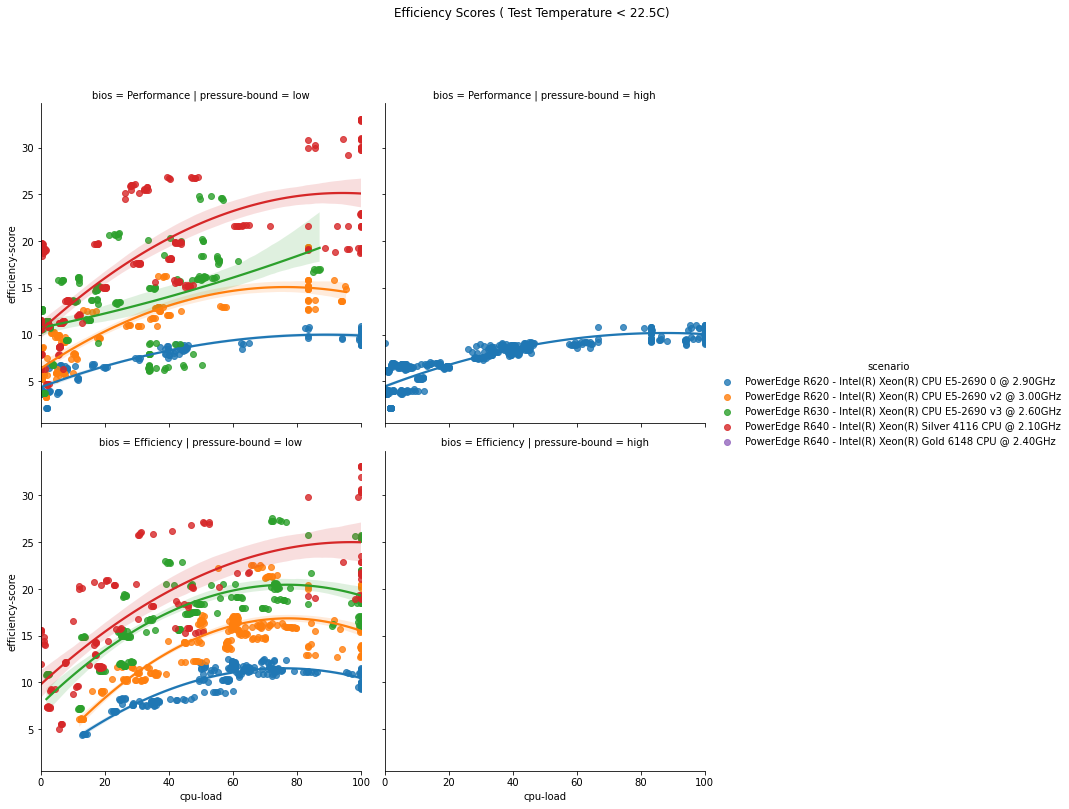

In [946]:
cpu_worklets = sert_data[(sert_data['workload'] == 'Idle') | (sert_data['workload'] == 'CPU')]
cpu_worklets['scenario'] = list(' - '.join(x) for x in zip(cpu_worklets['model'], cpu_worklets['cpu']))
sns.lmplot(x='cpu-load', y='efficiency-score', hue='scenario', col='pressure-bound', row='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < 30], order=2, truncate=True, scatter=True).fig.suptitle('Efficiency Scores ( Test Temperature < 22.5C)', y=1.1)


This is a significantly different relationship than that shown for the SERT load. 

Breaking down the performance per server and per worklet.

Text(0.5, 1.1, 'Efficiency Scores')

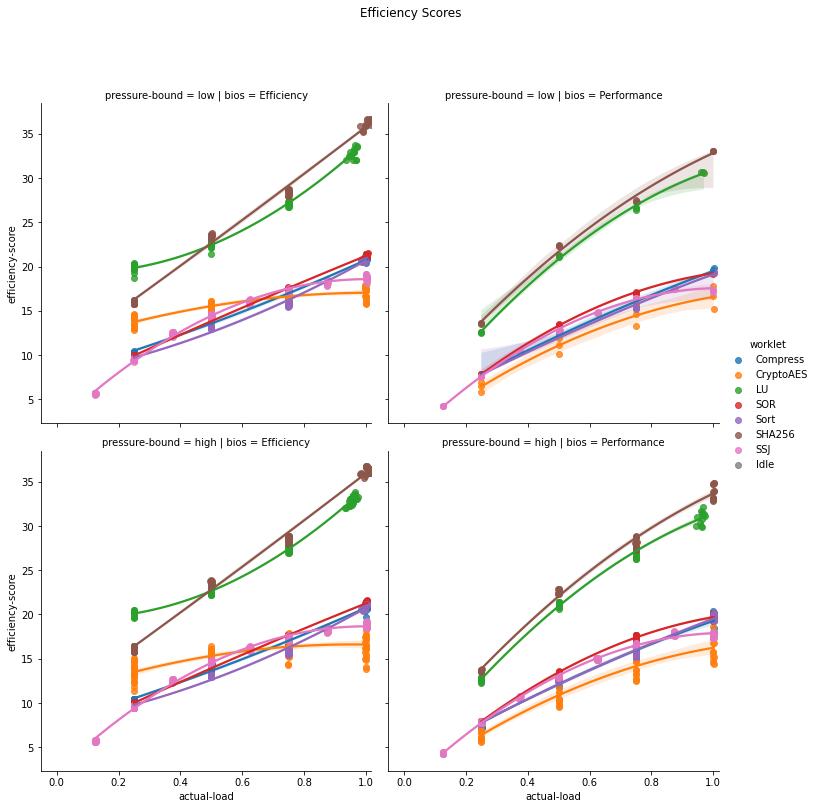

In [954]:

    sns.lmplot(x='actual-load', y='efficiency-score', hue='worklet', col='bios', row='scenario', data=cpu_worklets[cpu_worklets['scenario']=='PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz'], order=2, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


Text(0.5, 1.1, 'Efficiency Scores')

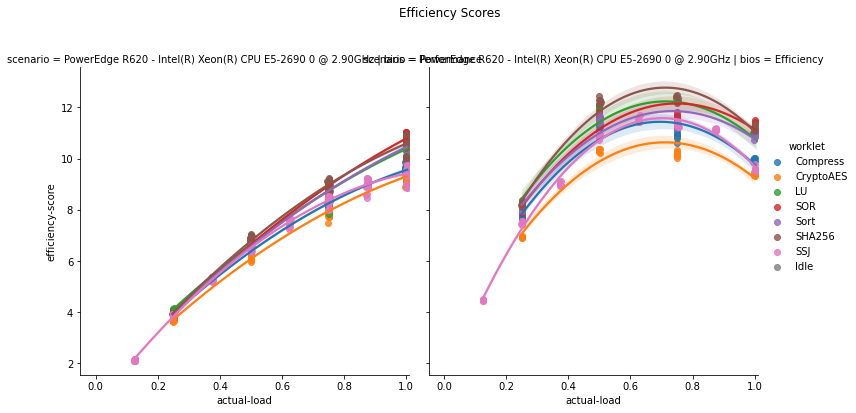

In [948]:

    sns.lmplot(x='actual-load', y='efficiency-score', hue='worklet', col='bios', row='scenario', data=cpu_worklets[cpu_worklets['scenario']=='PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz'], order=2, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


Text(0.5, 1.1, 'Efficiency Scores')

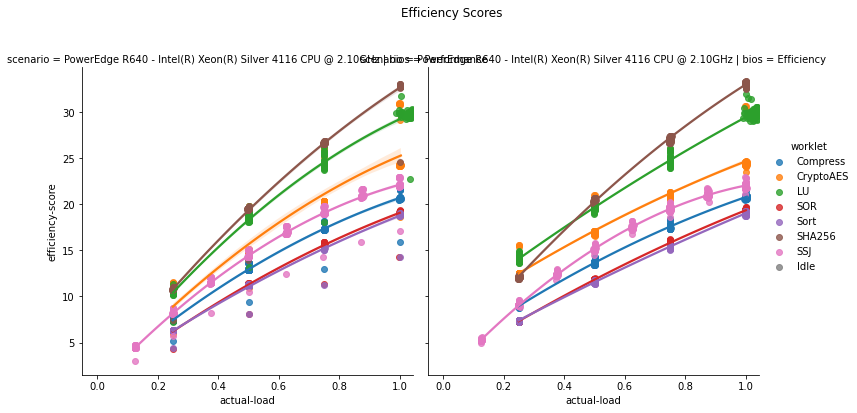

In [949]:

    sns.lmplot(x='actual-load', y='efficiency-score', hue='worklet', col='bios', row='scenario', data=cpu_worklets[cpu_worklets['scenario']=='PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz'], order=2, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


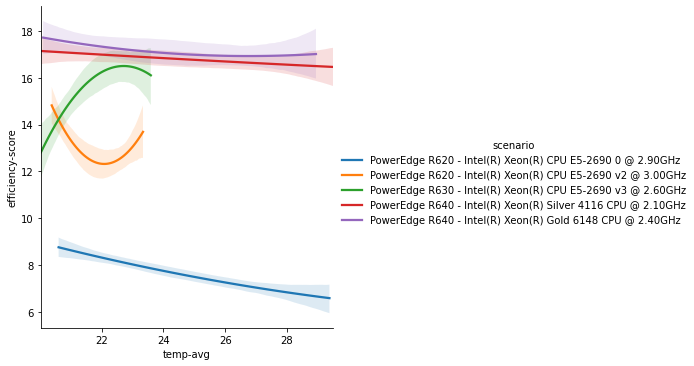

In [950]:
sns.lmplot(x='temp-avg', y='efficiency-score', hue='scenario', data=cpu_worklets, order=2, scatter=False)

# CPU power consumption

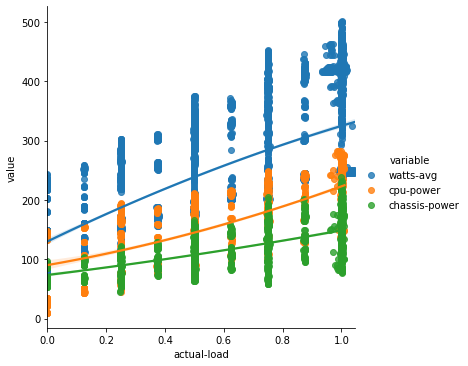

In [951]:
plotdf = cpu_worklets.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2)

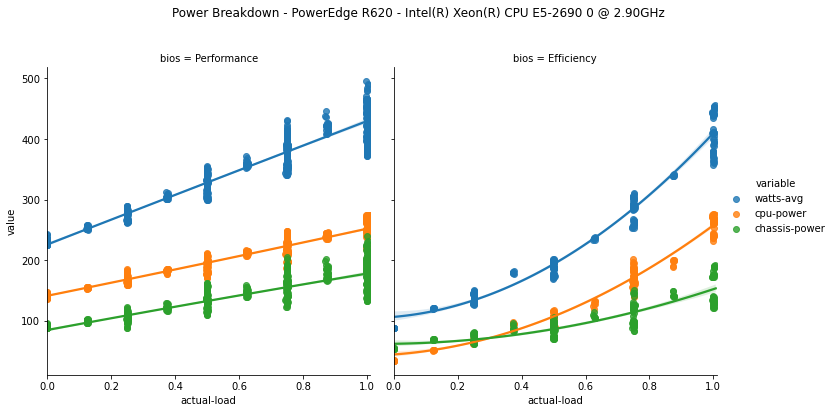

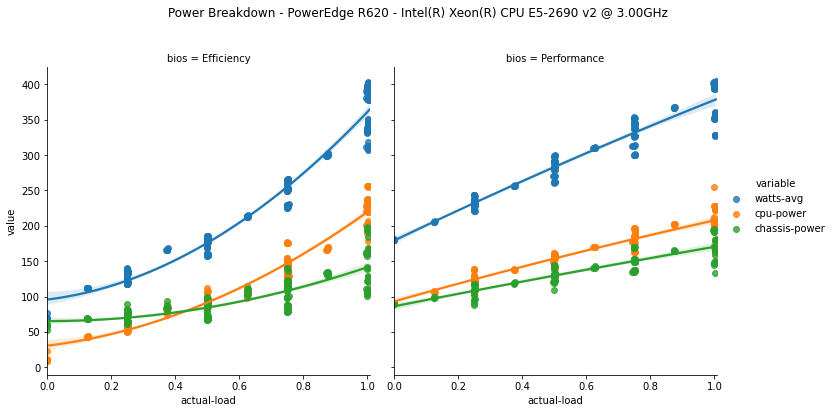

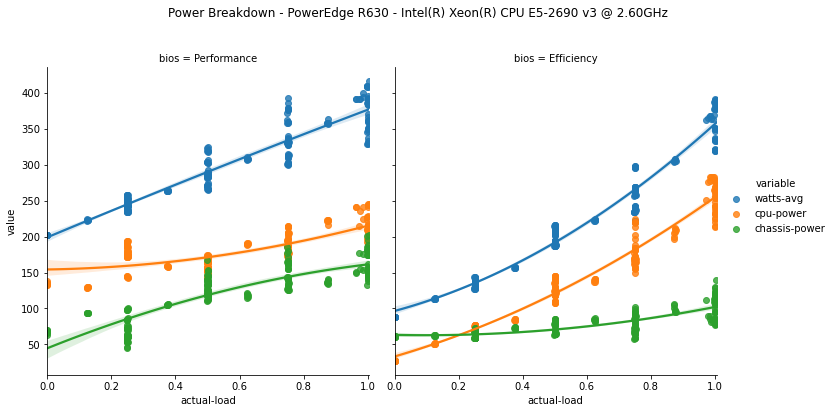

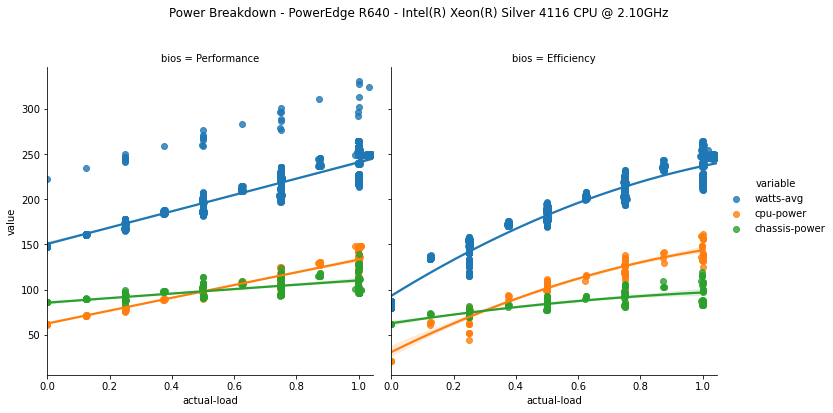

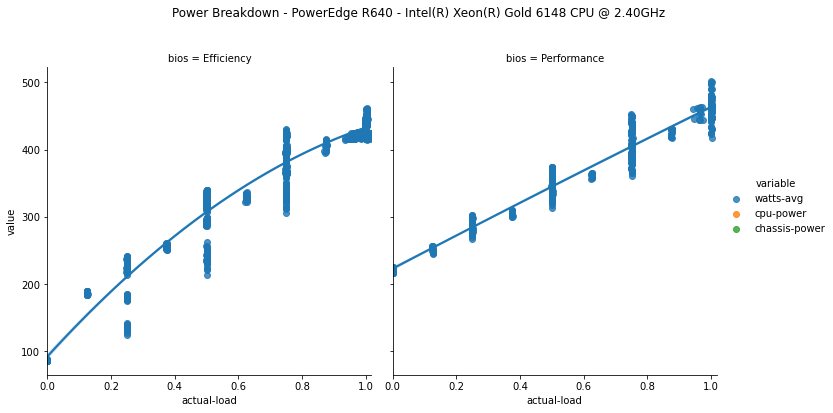

In [952]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['actual-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

In [953]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['cpu-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

KeyError: "['actual-load'] not in index"

In [ ]:
for worklet in sert_data[sert_data['workload'] == 'CPU']['worklet'].unique():
    sns.lmplot(data=sert_data[(sert_data['worklet'] == worklet) | (sert_data['workload'] == 'Idle')], x='actual-load', y='cpu-load', hue='scenario', col='bios', order=2).fig.suptitle(f'Server load vs CPU utilisaiton - {worklet}', y=1.1)

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['model'] == 'PowerEdge R620']
#cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]


#sns.lmplot(x='cpu-power', y='chassis-power', hue='worklet', data=cpu, order=2)
sns.scatterplot(x='temp-avg', y='watts-avg', hue='cpu', data=cpu)

In [ ]:
sns.lmplot(x='cpu-load', y='cpu-power', data=cpu, order=2)

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['temp-avg'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ambient Temp', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-freq'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Freq')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')